In [46]:
import os
import sys
import json
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from IPython.display import display, HTML, Markdown
from retrieve_lexical import load_tfidf_retriever, load_bm25_retriever
from retrieve_semantic import load_semantic_retriever
from retrieve_hybrid import HybridRetriever

In [ ]:
CURRENT_DIR = os.getcwd()
print("CWD:", CURRENT_DIR)

if os.path.basename(CURRENT_DIR) in ("notebooks", "src"):
    PROJECT_ROOT = os.path.dirname(CURRENT_DIR)
else:
    PROJECT_ROOT = CURRENT_DIR

print("PROJECT_ROOT:", PROJECT_ROOT)

SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

ARTIFACTS_DIR = os.path.join(PROJECT_ROOT, "artifacts")
DATA_DIR = os.path.join(PROJECT_ROOT, "data")

CHUNKS_PATH = os.path.join(ARTIFACTS_DIR, "bbc_chunks.jsonl")
CORPUS_CSV  = os.path.join(ARTIFACTS_DIR, "bbc_corpus.csv")

print("ARTIFACTS_DIR:", ARTIFACTS_DIR)
print("CORPUS_CSV:", CORPUS_CSV)
print("CHUNKS_PATH:", CHUNKS_PATH)


CWD: d:\Text_Web\Semantic-Lexical-Retrieval-for-News\src
PROJECT_ROOT: d:\Text_Web\Semantic-Lexical-Retrieval-for-News
ARTIFACTS_DIR: d:\Text_Web\Semantic-Lexical-Retrieval-for-News\artifacts
CORPUS_CSV: d:\Text_Web\Semantic-Lexical-Retrieval-for-News\artifacts\bbc_corpus.csv
CHUNKS_PATH: d:\Text_Web\Semantic-Lexical-Retrieval-for-News\artifacts\bbc_chunks.jsonl


In [48]:
# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Environment setup complete")
print(f"✓ Project root: {PROJECT_ROOT}")
print(f"✓ Artifacts directory: {ARTIFACTS_DIR}")

✓ Environment setup complete
✓ Project root: d:\Text_Web\Semantic-Lexical-Retrieval-for-News
✓ Artifacts directory: d:\Text_Web\Semantic-Lexical-Retrieval-for-News\artifacts


In [49]:
# Load corpus
print("Loading corpus...")
corpus_df = pd.read_csv(CORPUS_CSV)
print(f"✓ Loaded {len(corpus_df)} documents")

# Load chunks
print("\nLoading chunks...")
def load_chunks(path=CHUNKS_PATH):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

chunks_df = load_chunks()
print(f"✓ Loaded {len(chunks_df)} chunks")

# Initialize retrievers
print("\nInitializing retrievers...")
tfidf_retriever = load_tfidf_retriever(ARTIFACTS_DIR)
print("✓ TF-IDF loaded")

bm25_retriever = load_bm25_retriever(ARTIFACTS_DIR)
print("✓ BM25 loaded")

semantic_retriever = load_semantic_retriever(ARTIFACTS_DIR, use_faiss=True)
print("✓ Semantic loaded")

# Create hybrid retriever
hybrid_retriever = HybridRetriever({
    'tfidf': tfidf_retriever,
    'bm25': bm25_retriever,
    'semantic': semantic_retriever
}, fusion_method='rrf')
print("✓ Hybrid (RRF) loaded")

print("\n" + "="*60)
print("All retrievers ready!")
print("="*60)

Loading corpus...
✓ Loaded 2225 documents

Loading chunks...
✓ Loaded 2693 chunks

Initializing retrievers...
✓ TF-IDF loaded
✓ BM25 loaded
✓ Semantic loaded
✓ Hybrid (RRF) loaded

All retrievers ready!


DATASET STATISTICS

1. Category Distribution:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


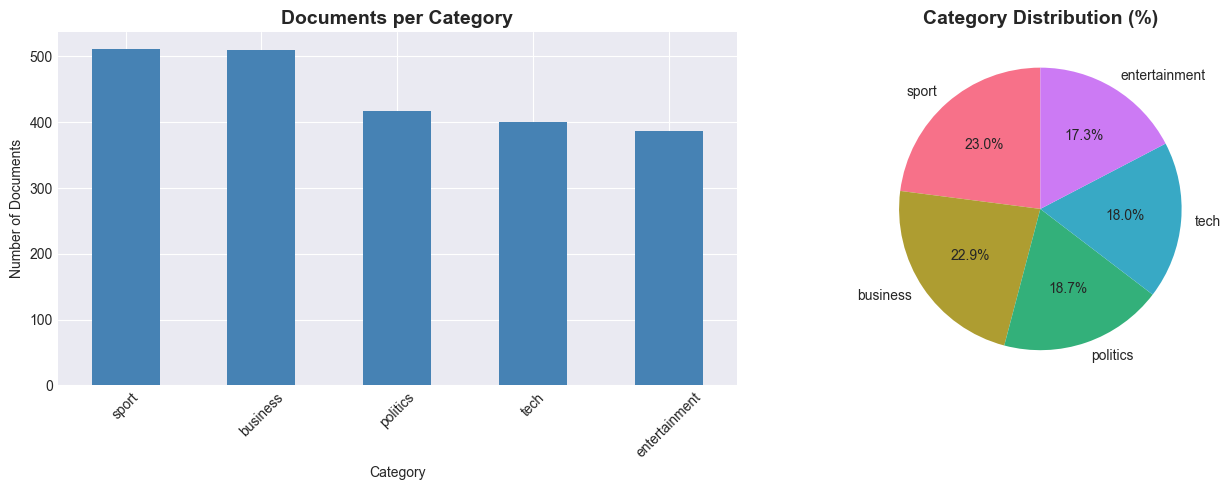


2. Document Length Statistics (words):
count    2225.000000
mean      378.785169
std       238.172565
min        84.000000
25%       240.000000
50%       326.000000
75%       466.000000
max      4427.000000
Name: word_count, dtype: float64

3. Chunk Statistics:
Total chunks: 2693
Avg chunks per document: 1.21
Chunk word count stats:
count    2693.000000
mean      332.700706
std       107.213114
min        84.000000
25%       244.000000
50%       329.000000
75%       433.000000
max       550.000000
Name: word_count, dtype: float64


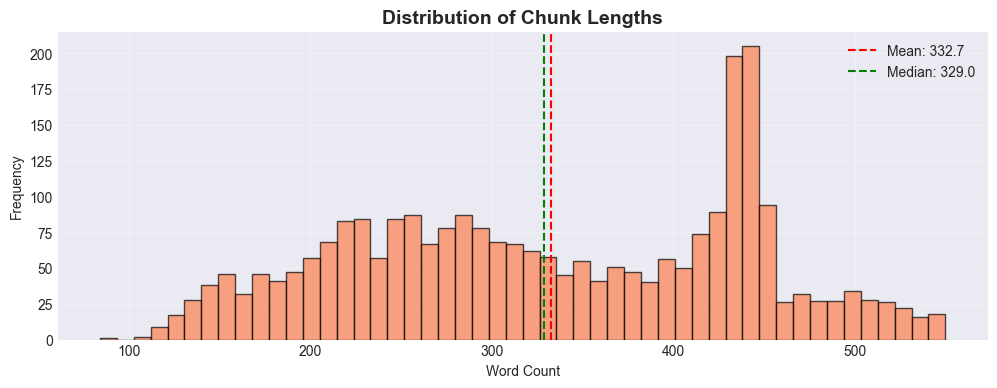


✓ Dataset analysis complete


In [50]:
print("=" * 70)
print("DATASET STATISTICS")
print("=" * 70)

# Category distribution
print("\n1. Category Distribution:")
category_counts = corpus_df['category'].value_counts()
print(category_counts)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
category_counts.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Documents per Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Number of Documents')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette("husl", len(category_counts)))
axes[1].set_title('Category Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Document length statistics
print("\n2. Document Length Statistics (words):")
corpus_df['word_count'] = corpus_df['text'].str.split().str.len()
print(corpus_df['word_count'].describe())

# Chunk statistics
print("\n3. Chunk Statistics:")
chunks_df['word_count'] = chunks_df['text'].str.split().str.len()
print(f"Total chunks: {len(chunks_df)}")
print(f"Avg chunks per document: {len(chunks_df) / len(corpus_df):.2f}")
print(f"Chunk word count stats:")
print(chunks_df['word_count'].describe())

# Visualize chunk lengths
plt.figure(figsize=(12, 4))
plt.hist(chunks_df['word_count'], bins=50, color='coral', edgecolor='black', alpha=0.7)
plt.axvline(chunks_df['word_count'].mean(), color='red', linestyle='--', 
            label=f'Mean: {chunks_df["word_count"].mean():.1f}')
plt.axvline(chunks_df['word_count'].median(), color='green', linestyle='--', 
            label=f'Median: {chunks_df["word_count"].median():.1f}')
plt.title('Distribution of Chunk Lengths', fontsize=14, fontweight='bold')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\n✓ Dataset analysis complete")

In [51]:
def display_results(results, label, max_chars=300, show_top_n=5):
    """Display search results in a formatted way"""
    print(f"\n{'='*80}")
    print(f"{label:^80}")
    print(f"{'='*80}")
    
    if not results:
        print("No results found.")
        return
    
    for idx, (doc_id, score) in enumerate(results[:show_top_n], 1):
        row = chunks_df.loc[chunks_df["id"] == doc_id].iloc[0]
        
        print(f"\n{idx}. [{doc_id}] | Category: {row['category']} | Score: {score:.4f}")
        print(f"   Title: {row['title']}")
        
        text = row["text"].replace("\n", " ")
        snippet = text[:max_chars] + "..." if len(text) > max_chars else text
        print(f"   Snippet: {snippet}")
        print("-" * 80)

def compare_results_overlap(results_dict, top_k=10):
    """Compare overlap between different retrieval methods"""
    print(f"\n{'='*80}")
    print(f"RESULTS OVERLAP ANALYSIS (Top-{top_k})")
    print(f"{'='*80}\n")
    
    # Get top-k doc IDs for each method
    top_docs = {}
    for method, results in results_dict.items():
        top_docs[method] = set([doc_id for doc_id, _ in results[:top_k]])
    
    # Pairwise comparison
    methods = list(results_dict.keys())
    for i, method1 in enumerate(methods):
        for method2 in methods[i+1:]:
            overlap = top_docs[method1] & top_docs[method2]
            jaccard = len(overlap) / len(top_docs[method1] | top_docs[method2])
            
            print(f"{method1} ∩ {method2}:")
            print(f"  Common documents: {len(overlap)}/{top_k}")
            print(f"  Jaccard similarity: {jaccard:.3f}")
            print()

def visualize_score_distribution(results_dict):
    """Visualize score distributions for different methods"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, (method, results) in enumerate(results_dict.items()):
        if results:
            scores = [score for _, score in results]
            
            axes[idx].hist(scores, bins=20, color=sns.color_palette("husl")[idx], 
                          edgecolor='black', alpha=0.7)
            axes[idx].set_title(f'{method} Score Distribution', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Score')
            axes[idx].set_ylabel('Frequency')
            axes[idx].axvline(np.mean(scores), color='red', linestyle='--', 
                             label=f'Mean: {np.mean(scores):.3f}')
            axes[idx].legend()
            axes[idx].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_category_distribution(results, label):
    """Analyze category distribution in results"""
    categories = []
    for doc_id, _ in results:
        row = chunks_df.loc[chunks_df["id"] == doc_id].iloc[0]
        categories.append(row['category'])
    
    category_counts = Counter(categories)
    
    print(f"\n{label} - Category Distribution in Top Results:")
    for cat, count in category_counts.most_common():
        print(f"  {cat}: {count} ({count/len(results)*100:.1f}%)")
    
    return category_counts

def create_results_dataframe(results_dict, top_k=10):
    """Create a comparative DataFrame of results"""
    data = []
    
    for method, results in results_dict.items():
        for rank, (doc_id, score) in enumerate(results[:top_k], 1):
            row = chunks_df.loc[chunks_df["id"] == doc_id].iloc[0]
            data.append({
                'Method': method,
                'Rank': rank,
                'Doc ID': doc_id,
                'Score': score,
                'Category': row['category'],
                'Title': row['title'][:50] + '...' if len(row['title']) > 50 else row['title']
            })
    
    return pd.DataFrame(data)

print("✓ Helper functions loaded")

✓ Helper functions loaded



QUERY ANALYSIS: 'economic impact of climate change'

Running retrievers...

                                     TF-IDF                                     

1. [politics_197_0] | Category: politics | Score: 0.2643
   Title: Blair 'pressing US on climate'
   Snippet: Tony Blair is pressing the US to cut greenhouse gases despite its unwillingness to sign the Kyoto Protocol, Downing Street has indicated. Officials have confirmed climate change was discussed when influential senator John McCain recently visited Mr Blair. Climate change was an issue the prime minist...
--------------------------------------------------------------------------------

2. [politics_090_0] | Category: politics | Score: 0.2561
   Title: MSPs hear renewed climate warning
   Snippet: Climate change could be completely out of control within several decades, the Scottish Environment Protection Agency is warning a committee of MSPs. Experts are giving evidence on the subject to the Scottish Parliament's environment

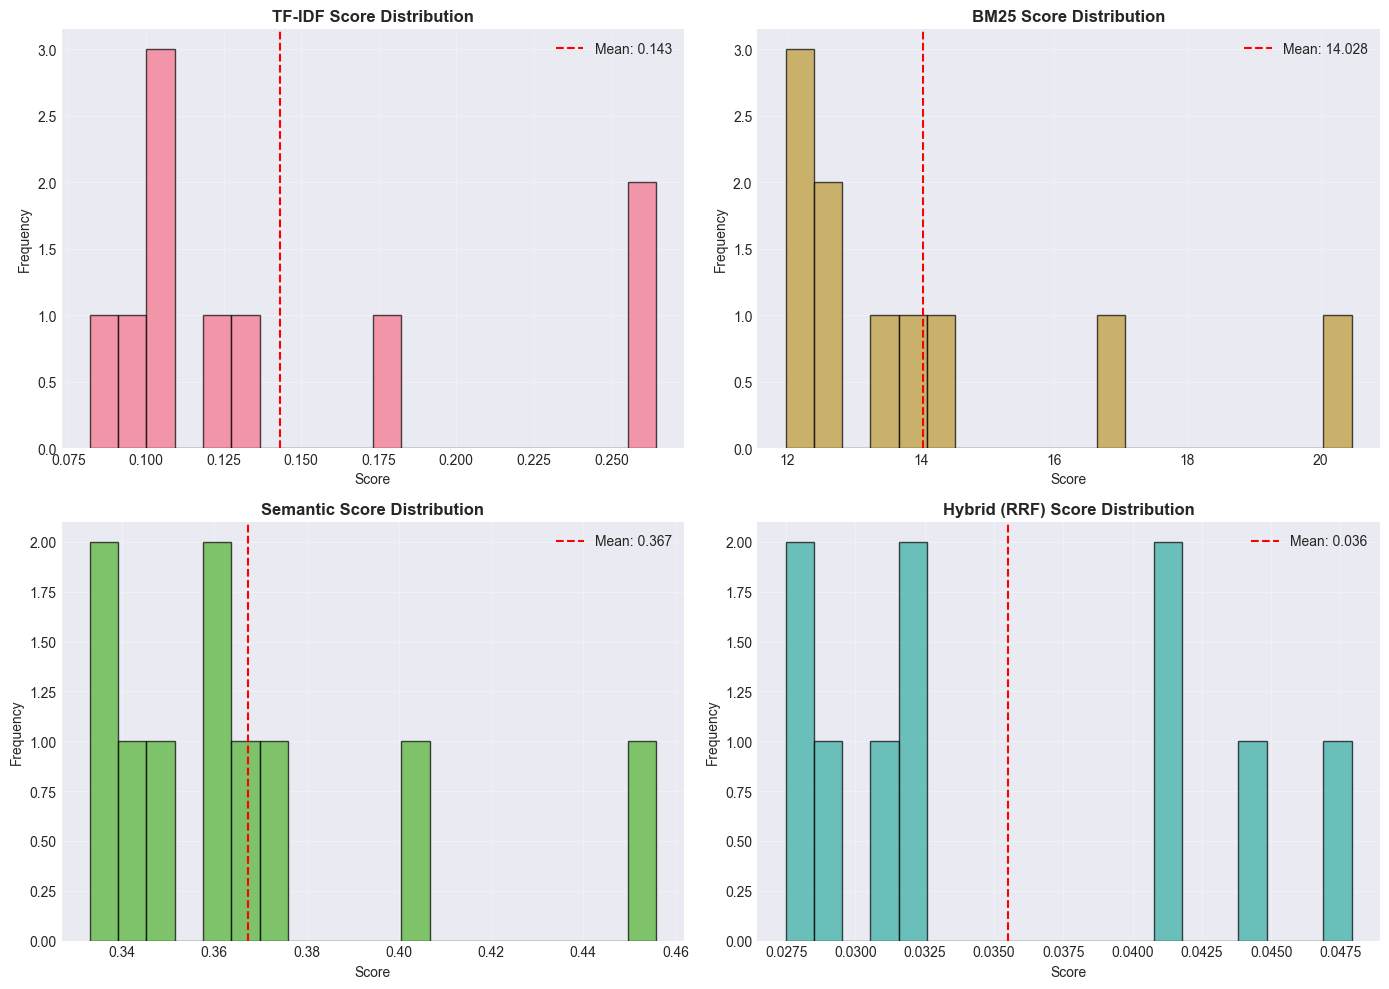


Category Distribution Analysis:

TF-IDF - Category Distribution in Top Results:
  business: 6 (60.0%)
  politics: 4 (40.0%)

BM25 - Category Distribution in Top Results:
  politics: 5 (50.0%)
  business: 5 (50.0%)

Semantic - Category Distribution in Top Results:
  business: 8 (80.0%)
  politics: 2 (20.0%)

Hybrid (RRF) - Category Distribution in Top Results:
  business: 6 (60.0%)
  politics: 4 (40.0%)

Comparative Results Table (Top 5):


,Method,Rank,Doc ID,Score,Category,Title
0,TF-IDF,1,politics_197_0,0.264331,politics,Blair 'pressing US on climate'
1,TF-IDF,2,politics_090_0,0.256095,politics,MSPs hear renewed climate warning
2,TF-IDF,3,politics_189_0,0.175661,politics,Blair congratulates Bush on win
3,TF-IDF,4,business_345_0,0.128020,business,Quake's economic costs emerging
4,TF-IDF,5,politics_029_0,0.127436,politics,UK set to cut back on embassies
5,BM25,1,politics_090_0,20.465219,politics,MSPs hear renewed climate warning
6,BM25,2,politics_197_0,16.769546,politics,Blair 'pressing US on climate'
7,BM25,3,politics_189_0,14.313928,politics,Blair congratulates Bush on win
8,BM25,4,business_094_0,13.756274,business,US economy shows solid GDP growth
9,BM25,5,business_504_0,13.354389,business,Aids and climate top Davos agenda


In [52]:
# Define query
query = "economic impact of climate change"
k = 10

print(f"\n{'='*80}")
print(f"QUERY ANALYSIS: '{query}'")
print(f"{'='*80}")

# Run all retrievers
print("\nRunning retrievers...")
results = {
    'TF-IDF': tfidf_retriever.search(query, k=k),
    'BM25': bm25_retriever.search(query, k=k),
    'Semantic': semantic_retriever.search(query, k=k),
    'Hybrid (RRF)': hybrid_retriever.search(query, k=k)
}

# Display results
for method, res in results.items():
    display_results(res, method, show_top_n=5)

# Compare overlap
compare_results_overlap(results, top_k=k)

# Visualize score distributions
print("\nScore Distribution Analysis:")
visualize_score_distribution(results)

# Category analysis
print("\nCategory Distribution Analysis:")
for method, res in results.items():
    analyze_category_distribution(res, method)

# Create comparative table
print("\nComparative Results Table (Top 5):")
results_df = create_results_dataframe(results, top_k=5)
display(results_df)


DETAILED METHOD COMPARISON

Query: 'technology innovation artificial intelligence'
--------------------------------------------------------------------------------

1. Results Count at Different K:
--------------------------------------------------------------------------------

K = 1:
  TF-IDF          |  1 unique documents
  BM25            |  1 unique documents
  Semantic        |  1 unique documents
  Hybrid          |  1 unique documents

K = 3:
  TF-IDF          |  3 unique documents
  BM25            |  3 unique documents
  Semantic        |  3 unique documents
  Hybrid          |  3 unique documents

K = 5:
  TF-IDF          |  5 unique documents
  BM25            |  5 unique documents
  Semantic        |  5 unique documents
  Hybrid          |  5 unique documents

K = 10:
  TF-IDF          | 10 unique documents
  BM25            | 10 unique documents
  Semantic        | 10 unique documents
  Hybrid          | 10 unique documents

K = 20:
  TF-IDF          | 20 unique document

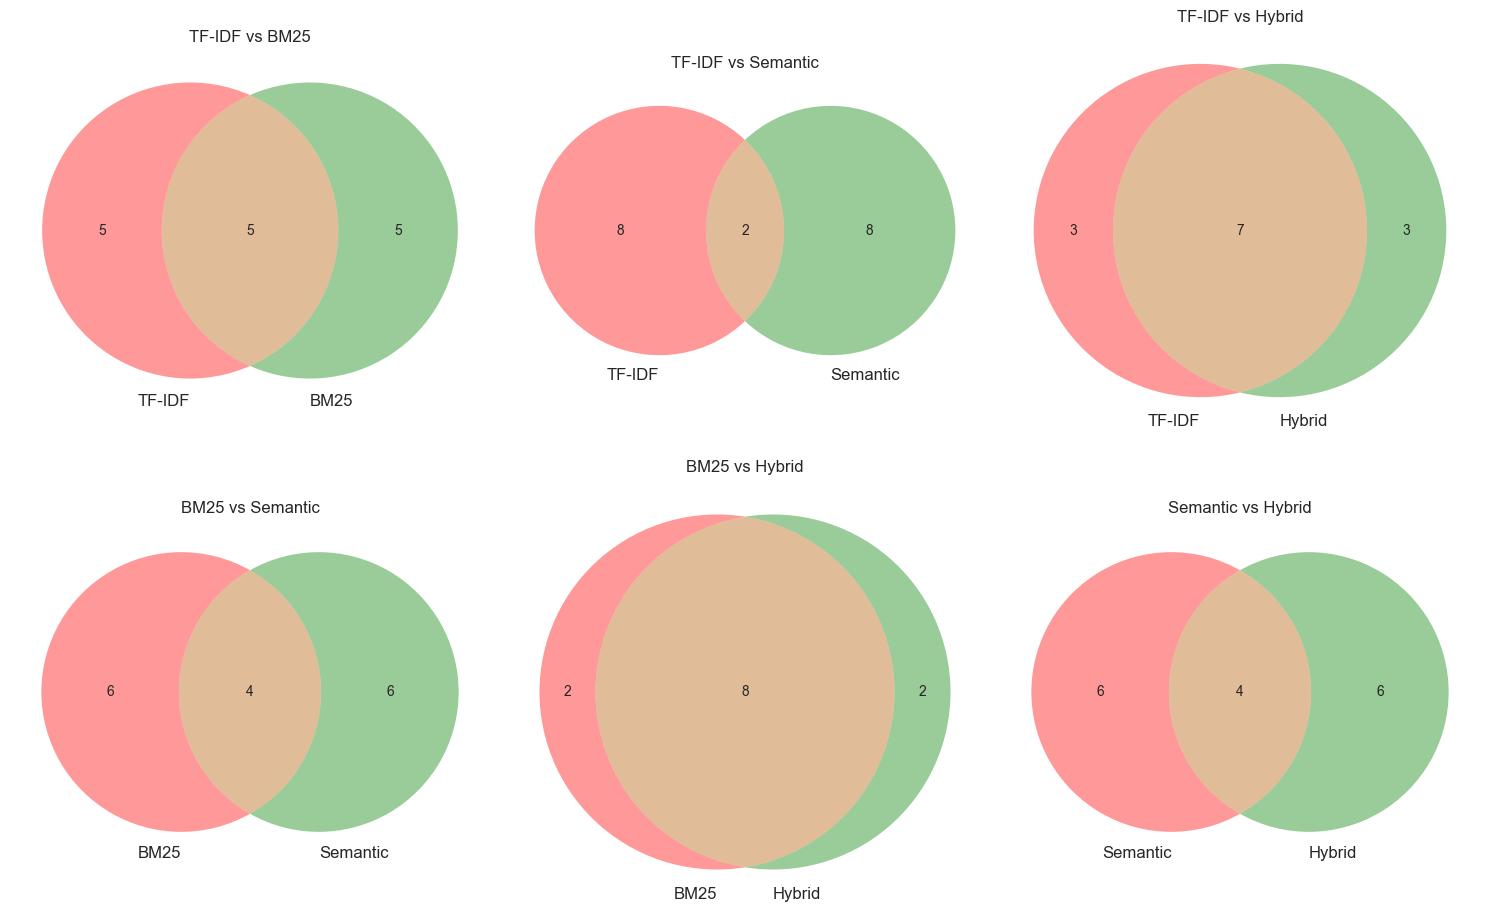

In [ ]:
print(f"\n{'='*80}")
print("DETAILED METHOD COMPARISON")
print(f"{'='*80}\n")

# Run comparison on a specific query
comparison_query = "technology innovation artificial intelligence"
print(f"Query: '{comparison_query}'")
print("-" * 80)

results_comparison = {
    'TF-IDF': tfidf_retriever.search(comparison_query, k=20),
    'BM25': bm25_retriever.search(comparison_query, k=20),
    'Semantic': semantic_retriever.search(comparison_query, k=20),
    'Hybrid': hybrid_retriever.search(comparison_query, k=20)
}

# Precision at K analysis
k_values = [1, 3, 5, 10, 20]
print("\n1. Results Count at Different K:")
print("-" * 80)
for k in k_values:
    print(f"\nK = {k}:")
    for method, results in results_comparison.items():
        unique_docs = len(set([doc_id for doc_id, _ in results[:k]]))
        print(f"  {method:15} | {unique_docs:2} unique documents")

# Score ranges
print("\n2. Score Range Analysis:")
print("-" * 80)
for method, results in results_comparison.items():
    if results:
        scores = [score for _, score in results]
        print(f"\n{method}:")
        print(f"  Range: {min(scores):.4f} - {max(scores):.4f}")
        print(f"  Spread: {max(scores) - min(scores):.4f}")

# Unique vs overlapping results
print("\n3. Unique Results Analysis (Top-10):")
print("-" * 80)
all_docs = set()
method_docs = {}
for method, results in results_comparison.items():
    docs = set([doc_id for doc_id, _ in results[:10]])
    method_docs[method] = docs
    all_docs.update(docs)

print(f"Total unique documents across all methods: {len(all_docs)}")
print()

for method, docs in method_docs.items():
    unique_to_method = docs - set.union(*[d for m, d in method_docs.items() if m != method])
    print(f"{method}:")
    print(f"  Unique to this method: {len(unique_to_method)}")
    if unique_to_method:
        for doc_id in list(unique_to_method)[:3]:
            doc = chunks_df.loc[chunks_df["id"] == doc_id].iloc[0]
            print(f"    - {doc['title'][:60]}")

# Visualize overlap with Venn-like representation
print("\n4. Method Overlap Visualization:")
from matplotlib_venn import venn2, venn3
from itertools import combinations

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

method_names = list(method_docs.keys())
idx = 0
for combo in combinations(method_names, 2):
    if idx < 6:
        set1 = method_docs[combo[0]]
        set2 = method_docs[combo[1]]
        
        venn2([set1, set2], set_labels=combo, ax=axes[idx])
        axes[idx].set_title(f'{combo[0]} vs {combo[1]}')
        idx += 1

plt.tight_layout()
plt.show()

In [54]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

In [ ]:

def create_interactive_search():
    
    # Header
    header = widgets.HTML(
        value="""
        <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                    padding: 20px; border-radius: 10px; margin-bottom: 20px;'>
            <h1 style='color: white; margin: 0; text-align: center;'>
                🔍 Semantic & Lexical Search
            </h1>
            <p style='color: white; text-align: center; margin: 10px 0 0 0;'>
                Type your query and explore different retrieval methods
            </p>
        </div>
        """
    )
    
    # Query input
    query_input = widgets.Textarea(
        value='',
        placeholder='Type your search query here (e.g., "economic impact of climate change")...',
        description='Query:',
        layout=widgets.Layout(width='95%', height='60px'),
        style={'description_width': '80px'}
    )
    
    # Method selection
    method_selector = widgets.RadioButtons(
        options=['All Methods (Comparison)', 
                 'TF-IDF', 
                 'BM25', 
                 'Semantic Embeddings', 
                 'Hybrid (RRF)'],
        value='Hybrid (RRF)',
        description='Method:',
        layout=widgets.Layout(width='50%'),
        style={'description_width': '80px'}
    )
    
    # Number of results
    k_slider = widgets.IntSlider(
        value=5,
        min=1,
        max=15,
        step=1,
        description='Results:',
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
        layout=widgets.Layout(width='40%'),
        style={'description_width': '80px'}
    )
    
    # Show snippets toggle
    show_snippets = widgets.Checkbox(
        value=True,
        description='Show text snippets',
        indent=False
    )
    
    # Show scores toggle
    show_scores = widgets.Checkbox(
        value=True,
        description='Show scores',
        indent=False
    )
    
    # Search button
    search_button = widgets.Button(
        description='🔍 Search',
        disabled=False,
        button_style='success',
        tooltip='Click to search',
        layout=widgets.Layout(width='200px', height='40px')
    )
    
    # Clear button
    clear_button = widgets.Button(
        description='🗑️ Clear',
        button_style='warning',
        tooltip='Clear results',
        layout=widgets.Layout(width='200px', height='40px')
    )
    
    # Output area
    output = widgets.Output(
        layout=widgets.Layout(
            border='1px solid #ddd',
            padding='10px',
            margin='10px 0',
            max_height='600px',
            overflow_y='auto'
        )
    )
    
    # Statistics area
    stats_output = widgets.Output()
    
    
    def display_single_result(doc_id, score, rank, method_name, show_snippet, show_score):
        """Display a single search result"""
        try:
            row = chunks_df.loc[chunks_df["id"] == doc_id].iloc[0]
            
            # Color coding by category
            category_colors = {
                'business': '#3498db',
                'entertainment': '#e74c3c',
                'politics': '#9b59b6',
                'sport': '#2ecc71',
                'tech': '#f39c12'
            }
            
            color = category_colors.get(row['category'], '#95a5a6')
            
            html = f"""
            <div style='border-left: 4px solid {color}; 
                        padding: 15px; 
                        margin: 10px 0; 
                        background-color: #f8f9fa;
                        border-radius: 5px;'>
                <div style='display: flex; justify-content: space-between; align-items: center;'>
                    <div style='flex: 1;'>
                        <strong style='font-size: 1.1em; color: #2c3e50;'>
                            {rank}. {row['title']}
                        </strong>
                    </div>
                    <div style='text-align: right;'>
            """
            
            if show_score:
                html += f"""
                        <span style='background-color: {color}; 
                                     color: white; 
                                     padding: 5px 12px; 
                                     border-radius: 15px; 
                                     font-weight: bold;
                                     font-size: 0.9em;'>
                            ⭐ {score:.4f}
                        </span>
                """
            
            html += f"""
                    </div>
                </div>
                <div style='margin: 8px 0; color: #7f8c8d; font-size: 0.9em;'>
                    <strong>{row['category'].title()}</strong> | 
                    <code>{doc_id}</code>
                </div>
            """
            
            if show_snippet:
                snippet = row['text'][:300].replace('\n', ' ').strip()
                html += f"""
                <div style='margin-top: 10px; 
                           padding: 10px; 
                           background-color: white; 
                           border-radius: 3px;
                           color: #34495e;
                           font-size: 0.95em;
                           line-height: 1.6;'>
                    {snippet}...
                </div>
                """
            
            html += "</div>"
            
            display(HTML(html))
            
        except Exception as e:
            print(f"Error displaying result: {e}")
    
    def display_method_header(method_name, result_count):
        """Display header for each method"""
        html = f"""
        <div style='background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
                    color: white;
                    padding: 15px;
                    margin: 20px 0 10px 0;
                    border-radius: 8px;
                    box-shadow: 0 2px 4px rgba(0,0,0,0.1);'>
            <h3 style='margin: 0; display: flex; justify-content: space-between; align-items: center;'>
                <span>{method_name}</span>
                <span style='font-size: 0.8em; background-color: rgba(255,255,255,0.2); 
                             padding: 5px 15px; border-radius: 15px;'>
                    {result_count} results
                </span>
            </h3>
        </div>
        """
        display(HTML(html))
    
    def show_statistics(results_dict):
        """Display search statistics"""
        with stats_output:
            clear_output()
            
            if not results_dict:
                return
            
            html = """
            <div style='background-color: #ecf0f1; padding: 15px; border-radius: 8px; margin: 20px 0;'>
                <h4 style='margin-top: 0; color: #2c3e50;'> Search Statistics</h4>
                <table style='width: 100%; border-collapse: collapse;'>
                    <tr style='background-color: #bdc3c7;'>
                        <th style='padding: 8px; text-align: left;'>Method</th>
                        <th style='padding: 8px; text-align: center;'>Results</th>
                        <th style='padding: 8px; text-align: center;'>Avg Score</th>
                        <th style='padding: 8px; text-align: center;'>Top Score</th>
                    </tr>
            """
            
            for method, results in results_dict.items():
                if results:
                    scores = [score for _, score in results]
                    avg_score = sum(scores) / len(scores)
                    top_score = max(scores)
                    
                    html += f"""
                    <tr style='background-color: white;'>
                        <td style='padding: 8px;'>{method}</td>
                        <td style='padding: 8px; text-align: center;'>{len(results)}</td>
                        <td style='padding: 8px; text-align: center;'>{avg_score:.4f}</td>
                        <td style='padding: 8px; text-align: center;'>{top_score:.4f}</td>
                    </tr>
                    """
            
            html += """
                </table>
            </div>
            """
            
            display(HTML(html))
    
    # === Search Function ===
    
    def perform_search(b):
        """Execute search when button is clicked"""
        # Clear previous outputs
        with output:
            clear_output()
        with stats_output:
            clear_output()
        
        query = query_input.value.strip()
        k = k_slider.value
        method_choice = method_selector.value
        show_snippet = show_snippets.value
        show_score = show_scores.value

        if not query:
            with output:
                display(HTML("""
                    <div style='background-color: #ffe6e6; 
                                border-left: 4px solid #e74c3c; 
                                padding: 15px; 
                                border-radius: 5px;'>
                        <strong>⚠️ Warning:</strong> Please enter a search query!
                    </div>
                """))
            return

        # Info banner
        with output:
            display(HTML(f"""
                <div style='background-color: #e8f4f8; 
                            border-left: 4px solid #3498db; 
                            padding: 15px; 
                            border-radius: 5px;
                            margin-bottom: 20px;'>
                    <strong>🔍 Searching for:</strong> "{query}"<br>
                    <strong>📊 Results to show:</strong> {k} per method<br>
                    <strong>🔧 Method:</strong> {method_choice}
                </div>
            """))

        method_map = {
            'TF-IDF': ('TF-IDF', tfidf_retriever),
            'BM25': ('BM25', bm25_retriever),
            'Semantic Embeddings': ('Semantic', semantic_retriever),
            'Hybrid (RRF)': ('Hybrid', hybrid_retriever),
        }

        # Decide which retrievers to run
        if method_choice == 'All Methods (Comparison)':
            # Run all methods
            methods_to_run = {name: ret for name, ret in method_map.values()}
        else:
            # Single method
            name, retriever = method_map[method_choice]
            methods_to_run = {name: retriever}

        # run all searches first, collect results only
        results_dict = {}
        for method_name, retriever in methods_to_run.items():
            try:
                results = retriever.search(query, k=k)
                results_dict[method_name] = results
            except Exception as e:
                results_dict[method_name] = []
                with output:
                    display(HTML(f"""
                        <div style='background-color: #ffe6e6; 
                                    border-left: 4px solid #e74c3c; 
                                    padding: 15px; margin-bottom: 10px;'>
                            <strong>❌ Error in {method_name}:</strong> {str(e)}
                        </div>
                    """))

        # show statistics ONLY in comparison mode
        if method_choice == 'All Methods (Comparison)' and len(methods_to_run) > 1:
            show_statistics(results_dict)

        # now display results for each method
        with output:
            for method_name, results in results_dict.items():
                display_method_header(method_name, len(results))

                if not results:
                    display(HTML("""
                        <div style='padding: 20px; text-align: center; color: #7f8c8d;'>
                            No results found for this query.
                        </div>
                    """))
                else:
                    for idx, (doc_id, score) in enumerate(results, 1):
                        display_single_result(
                            doc_id, score, idx, method_name,
                            show_snippet, show_score
                        )

    
    def clear_results(b):
        """Clear all outputs"""
        with output:
            clear_output()
        with stats_output:
            clear_output()
        query_input.value = ''
    

    search_button.on_click(perform_search)
    clear_button.on_click(clear_results)
    
    
    # Settings panel
    settings_panel = widgets.VBox([
        widgets.HBox([method_selector, 
                     widgets.VBox([k_slider, 
                                  widgets.HBox([show_snippets, show_scores])])
                     ])
    ])
    
    # Button panel
    button_panel = widgets.HBox([
        search_button,
        clear_button
    ], layout=widgets.Layout(justify_content='center', margin='10px 0'))
    
    # Complete interface
    interface = widgets.VBox([
        header,
        query_input,
        settings_panel,
        button_panel,
        stats_output,
        output
    ])
    
    # Display
    display(interface)
    
    # Show welcome message
    with output:
        display(HTML("""
            <div style='text-align: center; padding: 40px; color: #7f8c8d;'>
                <h3> Enter a query above and click Search to get started!</h3>
                <p>Try queries like:</p>
                <ul style='list-style: none; padding: 0;'>
                    <li> "economic impact of climate change"</li>
                    <li> "football transfer news"</li>
                    <li> "artificial intelligence technology"</li>
                    <li> "film awards entertainment"</li>
                </ul>
            </div>
        """))


create_interactive_search()